In [20]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import precision_recall_curve, accuracy_score
from datetime import datetime
import matplotlib.pyplot as plt

Utility functions for loading and processing the audio and preparing the model

In [21]:
def load_sample(file_path, target_duration = 5, sr = 16000):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=sr)
    
    # Calculate the target length in samples
    target_length = int(target_duration * sr)
    
    # Trim or pad the audio
    if len(audio) > target_length:
        audio = audio[:target_length]  # Trim
    elif len(audio) < target_length:
        pad_length = target_length - len(audio)
        audio = np.pad(audio, (0, pad_length), mode='constant')  # Pad with zeros
    
    return audio, sr

def feature_extraction(audio, sr):
    mel_spectrogram = librosa.feature.melspectrogram(y = audio, sr = sr, n_mels=128) # Mel spectrogram
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max) # Convert to log scale
    
    spectrogram = librosa.stft(y = audio)  # Short-Time Fourier Transform
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)

    mfcc = librosa.feature.mfcc(S=mel_spectrogram_db, sr=sr, n_mfcc = 128)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)

    return mel_spectrogram_db, spectrogram_db, mfcc, zero_crossing_rate

def build_model(input_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    
    return model

Plotting tools

In [22]:
def plot_precision_recall_curve(y_true, y_scores, timestamp):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker=".")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.savefig(os.path.join(os.getcwd(), 'results', f'pr_curve_{timestamp}'))
    plt.show()

def plot_training_history(history, timestamp):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.savefig(os.path.join(os.getcwd(), 'results', f'training_history_{timestamp}'))

    plt.show()

Loading the audio files and extracting features

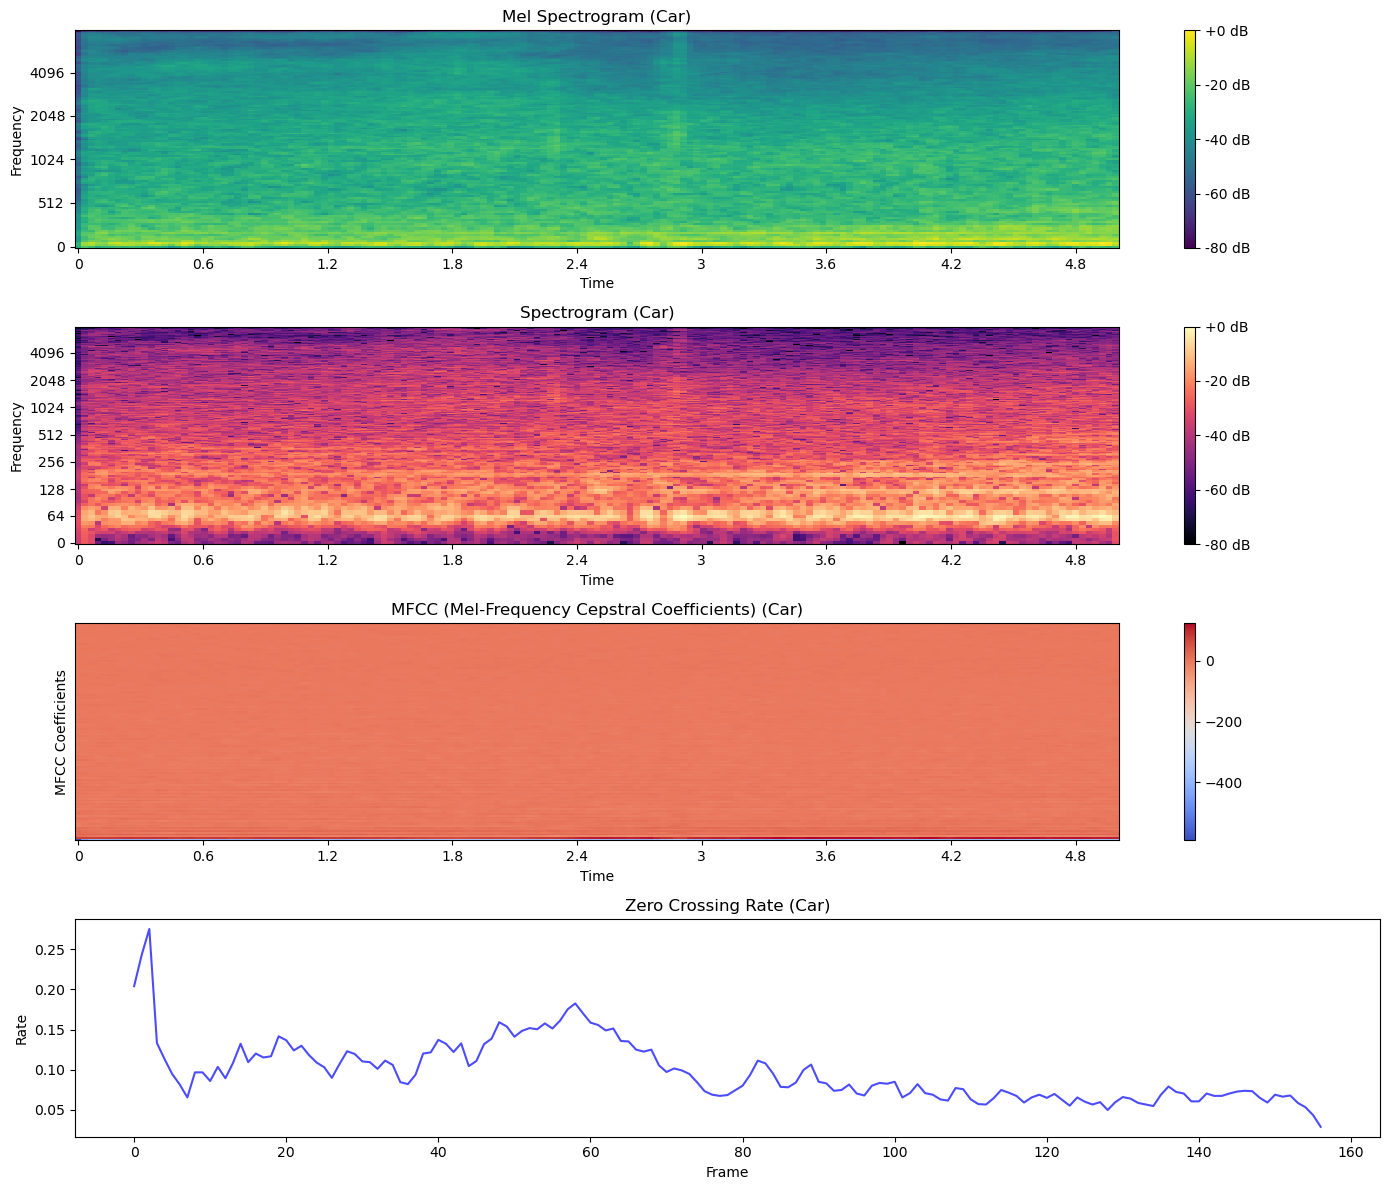

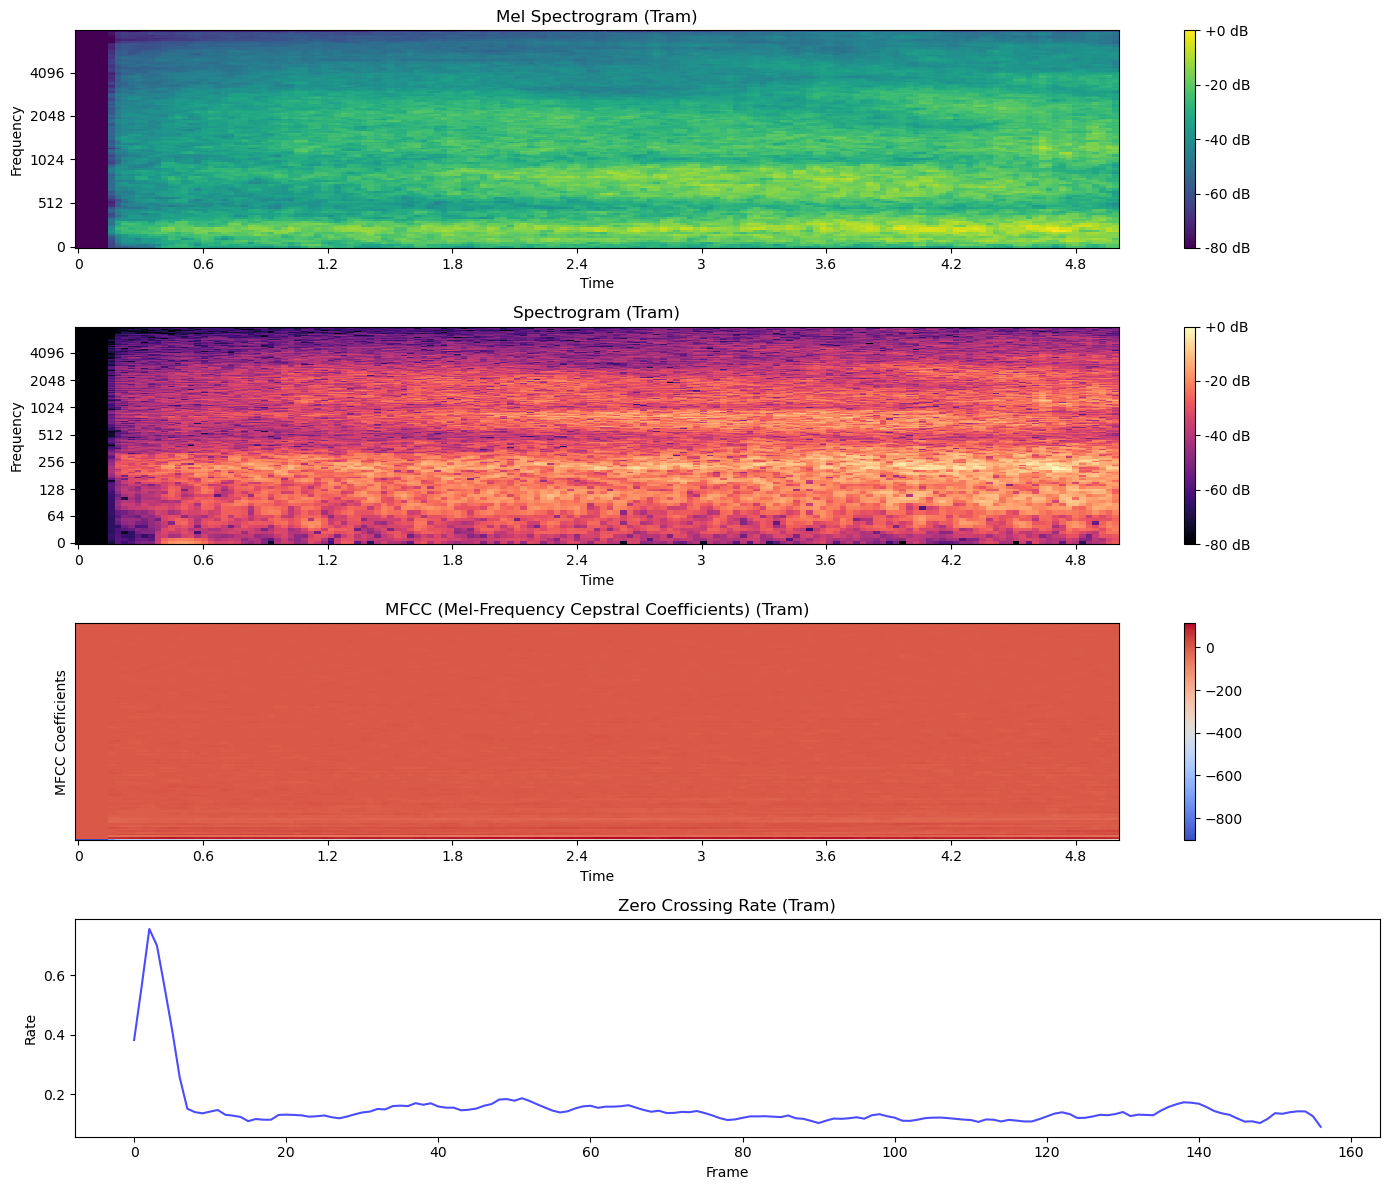

In [23]:
folder_path = os.getcwd()
# Data split roughly 80/10/10 (853 samples for training, 84 samples for validation and 104 samples for test)

X_train, Y_train = [], []
X_validate, Y_validate = [], []
X_test, Y_test = [], []

split_mapping = {
    "train": (X_train, Y_train),
    "validate": (X_validate, Y_validate),
    "test": (X_test, Y_test)
}

# Read data from folders inside the main folder
for split_name, (X_split, Y_split) in split_mapping.items():
    split_path = os.path.join(folder_path, 'dataset', split_name)
    
    # Process each .wav file in the split folder
    for file in os.listdir(split_path):
        if file.endswith('.wav'):
            file_path = os.path.join(split_path, file)
            label = 0 if file.startswith('car') else 1  # Encode labels (0: car, 1: tram)
            
            # Load audio and extract features
            audio, sr = load_sample(file_path)
            mel_spectrogram_db, spectrogram_db, mfcc, zero_crossing_rate = feature_extraction(audio, sr)

            # Plot the mel-scaled spectrogram
            if file_path == os.path.join(folder_path, 'dataset', "train", "car (1).wav") or file_path == os.path.join(folder_path, 'dataset', "train", "tram (1).wav"):
                vehicle_name = "Car" if "car" in file_path else "Tram"
                plt.figure(figsize=(14, 12))
                
                # Plot Mel Spectrogram
                plt.subplot(4, 1, 1)
                librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=512, x_axis="time", y_axis="mel", cmap="viridis")
                plt.colorbar(format="%+2.0f dB")
                plt.title(f"Mel Spectrogram ({vehicle_name})")
                plt.xlabel("Time")
                plt.ylabel("Frequency")
                
                # Plot Spectrogram
                plt.subplot(4, 1, 2)
                librosa.display.specshow(spectrogram_db, sr=sr, hop_length=512, x_axis="time", y_axis="log", cmap="magma")
                plt.colorbar(format="%+2.0f dB")
                plt.title(f"Spectrogram ({vehicle_name})")
                plt.xlabel("Time")
                plt.ylabel("Frequency")
                
                # Plot MFCCs
                plt.subplot(4, 1, 3)
                librosa.display.specshow(mfcc, sr=sr, hop_length=512, x_axis="time", cmap="coolwarm")
                plt.colorbar()
                plt.title(f"MFCC (Mel-Frequency Cepstral Coefficients) ({vehicle_name})")
                plt.xlabel("Time")
                plt.ylabel("MFCC Coefficients")
                
                # Plot Zero Crossing Rate
                plt.subplot(4, 1, 4)
                plt.plot(zero_crossing_rate[0], color="b", alpha=0.7)
                plt.title(f"Zero Crossing Rate ({vehicle_name})")
                plt.xlabel("Frame")
                plt.ylabel("Rate")
                
                plt.tight_layout()
                plt.show()

            # Using only mfcc for training the model
            features = mfcc

            # Append features and label to the respective split
            X_split.append(features)
            Y_split.append(label)
            
    # Casting lists to np.darrays
    split_mapping[split_name] = (np.array(X_split), np.array(Y_split))

X_train, Y_train = split_mapping["train"]
X_validate, Y_validate = split_mapping["validate"]
X_test, Y_test = split_mapping["test"]


Model creation and fitting

In [24]:
# Debug
print(X_test.shape, X_train.shape, X_validate.shape)
print(Y_test.shape, Y_train.shape, Y_validate.shape)
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # 1D image
model = build_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])   
history = model.fit(
    X_train, Y_train,
    validation_data=(X_validate, Y_validate),
    epochs=20
)

(104, 128, 157) (853, 128, 157) (84, 128, 157)
(104,) (853,) (84,)
Epoch 1/20
27/27 [==============================] - 6s 211ms/step - loss: 1.9708 - accuracy: 0.6905 - val_loss: 0.1277 - val_accuracy: 0.9643
Epoch 2/20
27/27 [==============================] - 5s 192ms/step - loss: 0.1795 - accuracy: 0.9449 - val_loss: 0.1178 - val_accuracy: 0.9524
Epoch 3/20
27/27 [==============================] - 5s 189ms/step - loss: 0.1496 - accuracy: 0.9508 - val_loss: 0.0362 - val_accuracy: 1.0000
Epoch 4/20
27/27 [==============================] - 5s 198ms/step - loss: 0.0864 - accuracy: 0.9707 - val_loss: 0.0216 - val_accuracy: 0.9881
Epoch 5/20
27/27 [==============================] - 5s 204ms/step - loss: 0.0527 - accuracy: 0.9836 - val_loss: 0.0194 - val_accuracy: 0.9881
Epoch 6/20
27/27 [==============================] - 9s 324ms/step - loss: 0.0454 - accuracy: 0.9859 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 7/20
27/27 [==============================] - 13s 495ms/step - loss: 0.0674

Predictions and result plots

4/4 [==============================] - 0s 36ms/step
Test Accuracy: 1.00


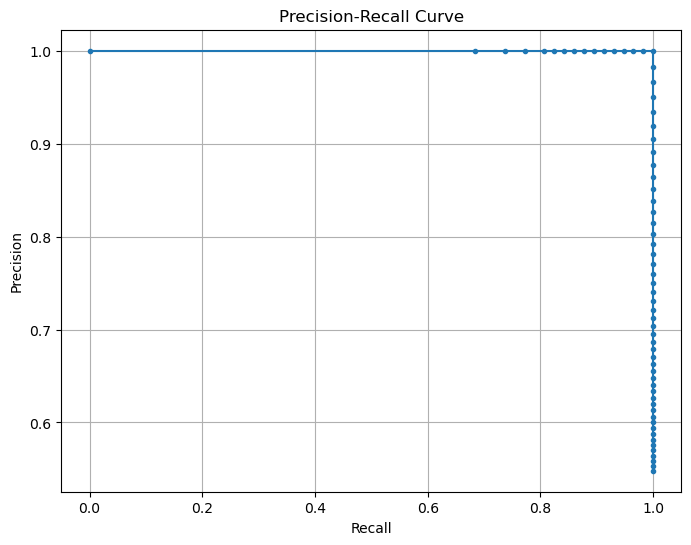

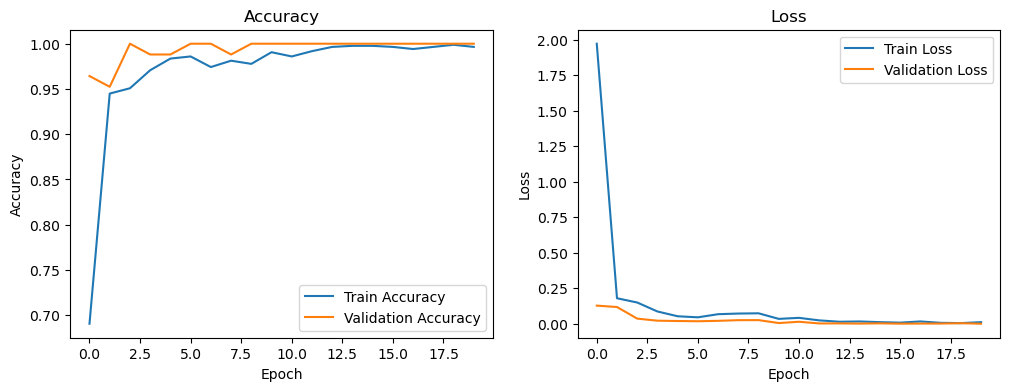

In [25]:
# Timestamp for file names
currTime = datetime.now()
timestamp = f'{currTime.year}_{currTime.month}_{currTime.day}_{currTime.hour}_{currTime.minute}__{currTime.second}'

Y_pred_prob = model.predict(X_test).ravel()
Y_pred = (Y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot Precision-Recall Curve
plot_precision_recall_curve(Y_test, Y_pred_prob, timestamp)

# Plot training history
plot_training_history(history, timestamp)